The following additional libraries are needed to run this
notebook. Note that running on Colab is experimental, please report a Github
issue if you have any problem.

In [ ]:
!pip install d2l==1.0.0-alpha0


# Weight Decay
:label:`sec_weight_decay`

Now that we have characterized the problem of overfitting,
we can introduce our first *regularization* technique.
Recall that we can always mitigate overfitting
by collecting more training data.
However, that can be costly, time consuming,
or entirely out of our control,
making it impossible in the short run.
For now, we can assume that we already have
as much high-quality data as our resources permit
and focus the tools at our disposal
even when the dataset is taken as a given.

Recall that in our polynomial regression example
(:numref:`subsec_polynomial-curve-fitting`)
we could limit our model's capacity
by tweaking the degree
of the fitted polynomial.
Indeed, limiting the number of features
is a popular technique to mitigate overfitting.
However, simply tossing aside features
can be too blunt an instrument.
Sticking with the polynomial regression
example, consider what might happen
with high-dimensional input.
The natural extensions of polynomials
to multivariate data are called *monomials*,
which are simply products of powers of variables.
The degree of a monomial is the sum of the powers.
For example, $x_1^2 x_2$, and $x_3 x_5^2$
are both monomials of degree 3.

Note that the number of terms with degree $d$
blows up rapidly as $d$ grows larger.
Given $k$ variables, the number of monomials
of degree $d$ (i.e., $k$ multichoose $d$) is ${k - 1 + d} \choose {k - 1}$.
Even small changes in degree, say from $2$ to $3$,
dramatically increase the complexity of our model.
Thus we often need a more fine-grained tool
for adjusting function complexity.

## Norms and Weight Decay

(**Rather than directly manipulating the number of parameters,
*weight decay*, operates by restricting the values 
that the parameters can take.**)
More commonly called $\ell_2$ regularization
outside of deep learning circles
when optimized by minibatch stochastic gradient descent,
weight decay might be the most widely used technique
for regularizing parametric machine learning models.
The technique is motivated by the basic intuition
that among all functions $f$,
the function $f = 0$
(assigning the value $0$ to all inputs)
is in some sense the *simplest*,
and that we can measure the complexity
of a function by the distance of its parameters from zero.
But how precisely should we measure
the distance between a function and zero?
There's no single right answer.
In fact, entire branches of mathematics,
including parts of functional analysis
and the theory of Banach spaces,
are devoted to addressing such issues.

One simple interpretation might be
to measure the complexity of a linear function
$f(\mathbf{x}) = \mathbf{w}^\top \mathbf{x}$
by some norm of its weight vector, e.g., $\| \mathbf{w} \|^2$.
Recall that we introduced the $\ell_2$ norm and $\ell_1$ norm,
which are special cases of the more general $\ell_p$ norm
in :numref:`subsec_lin-algebra-norms`.
The most common method for ensuring a small weight vector
is to add its norm as a penalty term
to the problem of minimizing the loss.
Thus we replace our original objective,
*minimizing the prediction loss on the training labels*,
with new objective,
*minimizing the sum of the prediction loss and the penalty term*.
Now, if our weight vector grows too large,
our learning algorithm might focus
on minimizing the weight norm $\| \mathbf{w} \|^2$
vs. minimizing the training error.
That is exactly what we want.
To illustrate things in code,
we revive our previous example
from :numref:`sec_linear_regression` for linear regression.
There, our loss was given by

$$L(\mathbf{w}, b) = \frac{1}{n}\sum_{i=1}^n \frac{1}{2}\left(\mathbf{w}^\top \mathbf{x}^{(i)} + b - y^{(i)}\right)^2.$$

Recall that $\mathbf{x}^{(i)}$ are the features,
$y^{(i)}$ is the label for any data example $i$, and $(\mathbf{w}, b)$
are the weight and bias parameters, respectively.
To penalize the size of the weight vector,
we must somehow add $\| \mathbf{w} \|^2$ to the loss function,
but how should the model trade off the
standard loss for this new additive penalty?
In practice, we characterize this tradeoff
via the *regularization constant* $\lambda$,
a non-negative hyperparameter
that we fit using validation data:

$$L(\mathbf{w}, b) + \frac{\lambda}{2} \|\mathbf{w}\|^2.$$


For $\lambda = 0$, we recover our original loss function.
For $\lambda > 0$, we restrict the size of $\| \mathbf{w} \|$.
We divide by $2$ by convention:
when we take the derivative of a quadratic function,
the $2$ and $1/2$ cancel out, ensuring that the expression
for the update looks nice and simple.
The astute reader might wonder why we work with the squared
norm and not the standard norm (i.e., the Euclidean distance).
We do this for computational convenience.
By squaring the $\ell_2$ norm, we remove the square root,
leaving the sum of squares of
each component of the weight vector.
This makes the derivative of the penalty easy to compute: 
the sum of derivatives equals the derivative of the sum.


Moreover, you might ask why we work with the $\ell_2$ norm
in the first place and not, say, the $\ell_1$ norm.
In fact, other choices are valid and
popular throughout statistics.
While $\ell_2$-regularized linear models constitute
the classic *ridge regression* algorithm,
$\ell_1$-regularized linear regression
is a similarly fundamental method in statistics, 
popularly known as *lasso regression*.
One reason to work with the $\ell_2$ norm
is that it places an outsize penalty
on large components of the weight vector.
This biases our learning algorithm
towards models that distribute weight evenly
across a larger number of features.
In practice, this might make them more robust
to measurement error in a single variable.
By contrast, $\ell_1$ penalties lead to models
that concentrate weights on a small set of features
by clearing the other weights to zero.
This gives us an effective method for *feature selection*,
which may be desirable for other reasons.
For example, if our model only relies on a few features,
then we may not need to collect, store, or transmit data
for the other (dropped) features. 

Using the same notation in :eqref:`eq_linreg_batch_update`,
the minibatch stochastic gradient descent updates
for $\ell_2$-regularized regression follow:

$$\begin{aligned}
\mathbf{w} & \leftarrow \left(1- \eta\lambda \right) \mathbf{w} - \frac{\eta}{|\mathcal{B}|} \sum_{i \in \mathcal{B}} \mathbf{x}^{(i)} \left(\mathbf{w}^\top \mathbf{x}^{(i)} + b - y^{(i)}\right).
\end{aligned}$$

As before, we update $\mathbf{w}$ based on the amount
by which our estimate differs from the observation.
However, we also shrink the size of $\mathbf{w}$ towards zero.
That is why the method is sometimes called "weight decay":
given the penalty term alone,
our optimization algorithm *decays*
the weight at each step of training.
In contrast to feature selection,
weight decay offers us a continuous mechanism
for adjusting the complexity of a function.
Smaller values of $\lambda$ correspond
to less constrained $\mathbf{w}$,
whereas larger values of $\lambda$
constrain $\mathbf{w}$ more considerably.
Whether we include a corresponding bias penalty $b^2$ 
can vary across implementations, 
and may vary across layers of a neural network.
Often, we do not regularize the bias term.
Besides,
although $\ell_2$ regularization may not be equivalent to weight decay for other optimization algorithms,
the idea of regularization through
shrinking the size of weights
still holds true.



## High-Dimensional Linear Regression

We can illustrate the benefits of weight decay 
through a simple synthetic example.


In [1]:
%matplotlib inline
import tensorflow as tf
from d2l import tensorflow as d2l

First, we [**generate some data as before**]:

(**$$y = 0.05 + \sum_{i = 1}^d 0.01 x_i + \epsilon \text{ where }
\epsilon \sim \mathcal{N}(0, 0.01^2).$$**)

In this synthetic dataset, our label is given 
by an underlying linear function of our inputs,
corrupted by Gaussian noise 
with zero mean and standard deviation 0.01.
For illustrative purposes, 
we can make the effects of overfitting pronounced,
by increasing the dimensionality of our problem to $d = 200$
and working with a small training set with only 20 examples.


In [2]:
class Data(d2l.DataModule):
    def __init__(self, num_train, num_val, num_inputs, batch_size):
        self.save_hyperparameters()
        n = num_train + num_val
        self.X = tf.random.normal((n, num_inputs))
        noise = tf.random.normal((n, 1)) * 0.01
        w, b = tf.ones((num_inputs, 1)) * 0.01, 0.05
        self.y = tf.matmul(self.X, w) + b + noise

    def get_dataloader(self, train):
        i = slice(0, self.num_train) if train else slice(self.num_train, None)
        return self.get_tensorloader([self.X, self.y], train, i)

## Implementation from Scratch

Now, let's try implementing weight decay from scratch.
Since minibatch stochastic gradient descent
is our optimizer,
we just need to add the squared $\ell_2$ penalty
to the original loss function.

### (**Defining $\ell_2$ Norm Penalty**)

Perhaps the most convenient way to implement this penalty
is to square all terms in place and sum them up.


In [3]:
def l2_penalty(w):
    return tf.reduce_sum(w**2) / 2

### Defining the Model

In the final model,
the linear regression and the squared loss have not changed since :numref:`sec_linear_scratch`,
so we will just define a subclass of `d2l.LinearRegressionScratch`. The only change here is that our loss now includes the penalty term.


In [4]:
class WeightDecayScratch(d2l.LinearRegressionScratch):
    def __init__(self, num_inputs, lambd, lr, sigma=0.01):
        super().__init__(num_inputs, lr, sigma)
        self.save_hyperparameters()

    def loss(self, y_hat, y):
        return super().loss(y_hat, y) + self.lambd * l2_penalty(self.w)

The following code fits our model on the training set with 20 examples and evaluates it on the validation set with 100 examples.


In [5]:
data = Data(num_train=20, num_val=100, num_inputs=200, batch_size=5)
trainer = d2l.Trainer(max_epochs=10)

def train_scratch(lambd):
    model = WeightDecayScratch(num_inputs=200, lambd=lambd, lr=0.01)
    model.board.yscale='log'
    trainer.fit(model, data)
    print('L2 norm of w:', float(l2_penalty(model.w)))

### [**Training without Regularization**]

We now run this code with `lambd = 0`,
disabling weight decay.
Note that we overfit badly,
decreasing the training error but not the
validation error---a textbook case of overfitting.


L2 norm of w: 0.009064711630344391


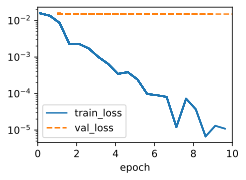

In [6]:
train_scratch(0)

### [**Using Weight Decay**]

Below, we run with substantial weight decay.
Note that the training error increases
but the validation error decreases.
This is precisely the effect
we expect from regularization.


L2 norm of w: 0.0015909627545624971


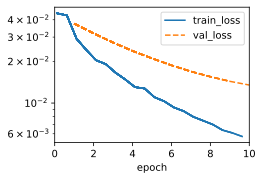

In [7]:
train_scratch(3)

## [**Concise Implementation**]

Because weight decay is ubiquitous
in neural network optimization,
the deep learning framework makes it especially convenient,
integrating weight decay into the optimization algorithm itself
for easy use in combination with any loss function.
Moreover, this integration serves a computational benefit,
allowing implementation tricks to add weight decay to the algorithm,
without any additional computational overhead.
Since the weight decay portion of the update
depends only on the current value of each parameter,
the optimizer must touch each parameter once anyway.


In the following code, we create an $\ell_2$ regularizer with
the weight decay hyperparameter `wd` and apply it to the layer's weights
through the `kernel_regularizer` argument.


In [8]:
class WeightDecay(d2l.LinearRegression):
    def __init__(self, wd, lr):
        super().__init__(lr)
        self.save_hyperparameters()
        self.net = tf.keras.layers.Dense(
            1, kernel_regularizer=tf.keras.regularizers.l2(wd),
            kernel_initializer=tf.keras.initializers.RandomNormal(0, 0.01)
        )

    def loss(self, y_hat, y):
        return super().loss(y_hat, y) + self.net.losses

[**The plot looks similar to that when
we implemented weight decay from scratch**].
However, this version runs faster
and is easier to implement,
benefits that will become more
pronounced as you address larger problems
and this work becomes more routine.


L2 norm of w: 0.0009396849782206118


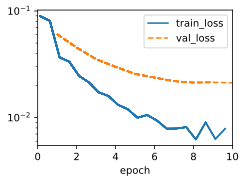

In [9]:
model = WeightDecay(wd=3, lr=0.01)
model.board.yscale='log'
trainer.fit(model, data)
print('L2 norm of w:', float(l2_penalty(model.get_w_b()[0])))

So far, we only touched upon one notion of
what constitutes a simple linear function.
Moreover, what constitutes a simple nonlinear function
can be an even more complex question.
For instance, [reproducing kernel Hilbert space (RKHS)](https://en.wikipedia.org/wiki/Reproducing_kernel_Hilbert_space)
allows one to apply tools introduced
for linear functions in a nonlinear context.
Unfortunately, RKHS-based algorithms
tend to scale poorly to large, high-dimensional data.
In this book we will often adopt the common heuristic
whereby weight decay is applied
to all layers of a deep network.

## Summary

* Regularization is a common method for dealing with overfitting. Classical regularization techniques add a penalty term to the loss function (when training) to reduce the complexity of the learned model.
* One particular choice for keeping the model simple is using an $\ell_2$ penalty. This leads to weight decay in the update steps of the minibatch stochastic gradient descent algorithm.
* The weight decay functionality is provided in optimizers from deep learning frameworks.
* Different sets of parameters can have different update behaviors within the same training loop.



## Exercises

1. Experiment with the value of $\lambda$ in the estimation problem in this section. Plot training and validation accuracy as a function of $\lambda$. What do you observe?
1. Use a validation set to find the optimal value of $\lambda$. Is it really the optimal value? Does this matter?
1. What would the update equations look like if instead of $\|\mathbf{w}\|^2$ we used $\sum_i |w_i|$ as our penalty of choice ($\ell_1$ regularization)?
1. We know that $\|\mathbf{w}\|^2 = \mathbf{w}^\top \mathbf{w}$. Can you find a similar equation for matrices (see the Frobenius norm in :numref:`subsec_lin-algebra-norms`)?
1. Review the relationship between training error and generalization error. In addition to weight decay, increased training, and the use of a model of suitable complexity, what other ways can you think of to deal with overfitting?
1. In Bayesian statistics we use the product of prior and likelihood to arrive at a posterior via $P(w \mid x) \propto P(x \mid w) P(w)$. How can you identify $P(w)$ with regularization?


[Discussions](https://discuss.d2l.ai/t/236)
